In [1]:
import os
import math
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import clima_anom as ca

from scipy.stats import spearmanr

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import mev_quant, pre_quantiles, quantile_correction
from ART_preprocessing import relative_error

In [2]:
product, resolution, yy_s, yy_e = 'IMERG', '01x01', 2001, 2023
# product, resolution, yy_s, yy_e = 'IMERG', '025x025', 2001, 2023
# product, resolution, yy_s, yy_e = 'CMORPH', '025x025', 1998, 2023

yys_cut = 2001
yye_cut = 2023

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Weibull')
dir_shape = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

In [4]:
veneto_dir = os.path.join(dir_shape,'Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [5]:
if product == 'IMERG' and resolution == '025x025':
    data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_{product}_{resolution}_{yy_s}_{yy_e}.nc')
else:
    data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_{product}_{yy_s}_{yy_e}.nc')

print(f'Product load: {data_dir}')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))
DATA_time = DATA['time'].values
lat, lon = DATA['lat'].values, DATA['lon'].values
lon2d, lat2d = np.meshgrid(lon, lat)

Product load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_IMERG_2001_2023.nc


In [6]:
if product == 'IMERG' and resolution == '025x025':
    OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_{product}_{resolution}_1981_2023.nc')
else:
    OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_{product}_1981_2023.nc')

print(f'OBS load: {data_dir}')
OBS = xr.open_dataset(OBS_dir)
OBS = OBS.sel(time=OBS.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

OBS_time = OBS['time'].values

OBS load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_IMERG_2001_2023.nc


In [7]:
def CORR_2d(DATA1, DATA2):
    
    if DATA1.shape[0] != DATA2.shape[0] or DATA1.shape[1] != DATA2.shape[1]:
        print('ERROR diferents dimension')
        return 0

    CORR_ = np.empty((DATA1.shape[1], DATA1.shape[2]))
    for i in range(DATA1.shape[1]):
        for j in range(DATA1.shape[2]):
            data1 = DATA1[:, i, j]
            data2 = DATA2[:, i, j]
            if np.isnan(data1).all() or np.isnan(data2).all():
                CORR_[i, j] = np.nan
            else:
                correlation, _ = spearmanr(data1, data2, nan_policy='omit')
                CORR_[i, j] = correlation

    return CORR_

def RMSE_2d(DATA1, DATA2):
    """
    Calculate the RMSE for 2D spatial data arrays across the time dimension.
    
    Parameters:
    DATA1, DATA2 : numpy.ndarray
        Arrays with the same shape (time, lat, lon).
    
    Returns:
    RMSE_ : numpy.ndarray
        A 2D array (lat, lon) containing the RMSE values.
    """
    if DATA1.shape != DATA2.shape:
        print('ERROR: Different dimensions')
        return None

    # Initialize the RMSE array
    RMSE_ = np.empty((DATA1.shape[1], DATA1.shape[2]))

    # Loop through each spatial point (lat, lon)
    for i in range(DATA1.shape[1]):
        for j in range(DATA1.shape[2]):
            data1 = DATA1[:, i, j]
            data2 = DATA2[:, i, j]

            # Check for all NaN values
            if np.isnan(data1).all() or np.isnan(data2).all():
                RMSE_[i, j] = np.nan
            else:
                # Compute RMSE ignoring NaN values
                valid_idx = ~np.isnan(data1) & ~np.isnan(data2)
                squared_diff = (data1[valid_idx] - data2[valid_idx]) ** 2
                RMSE_[i, j] = np.sqrt(np.mean(squared_diff))

    return RMSE_

def round_down_to_nearest_10(number):
    return (number // 10) * 10

def round_up_to_nearest_10(number):
    return math.ceil(number / 10) * 10

In [8]:
mask = ~np.isnan(np.nanmean(OBS['Wetdays'].values,axis=0))

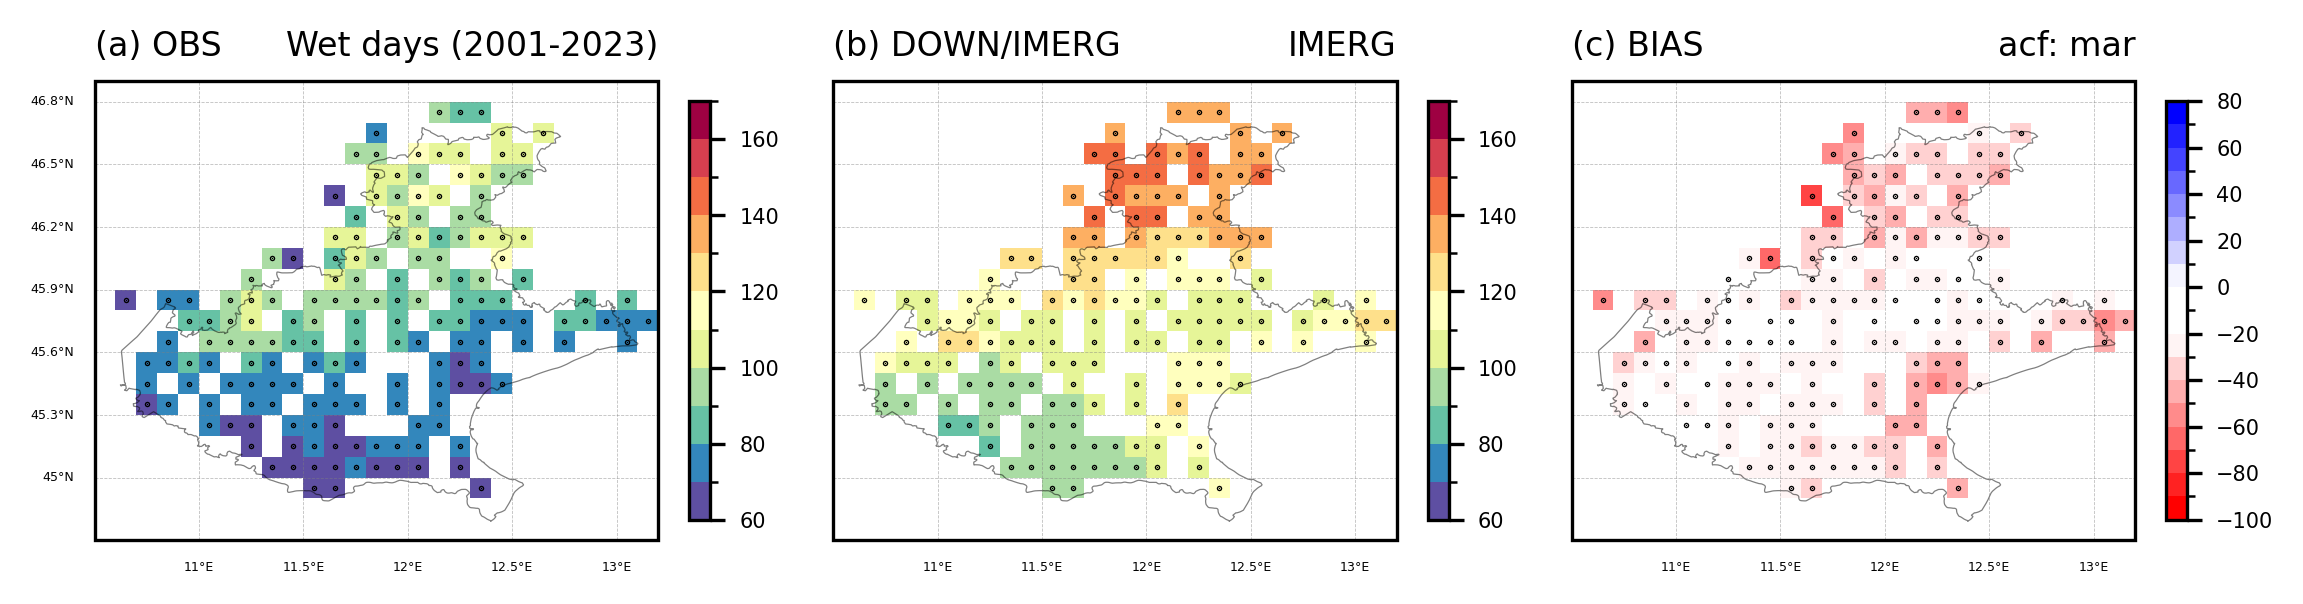

In [9]:
OBS_mean = np.nanmean(OBS['Wetdays'].values,axis=0)
DOWN_mean = np.nanmean(DATA['DOWN_WD'].values,axis=0)

levels_wd = np.arange(60,180,10)
norm_wd = mcolors.BoundaryNorm(boundaries=levels_wd, ncolors=256)

levels_diff = np.arange(-100,90,10)
norm_diff = mcolors.BoundaryNorm(boundaries=levels_diff, ncolors=256)

cmap_wd = plt.cm.Spectral_r
cmpa_diff = plt.cm.bwr_r
cmpa_diff = ca.colorbar_middle_white(cmpa_diff)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) OBS', fontsize=8, loc='left')
ax1.set_title(f'Wet days ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, DOWN_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) DOWN/IMERG', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean-DOWN_mean, cmap=cmpa_diff, norm=norm_diff)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) BIAS', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

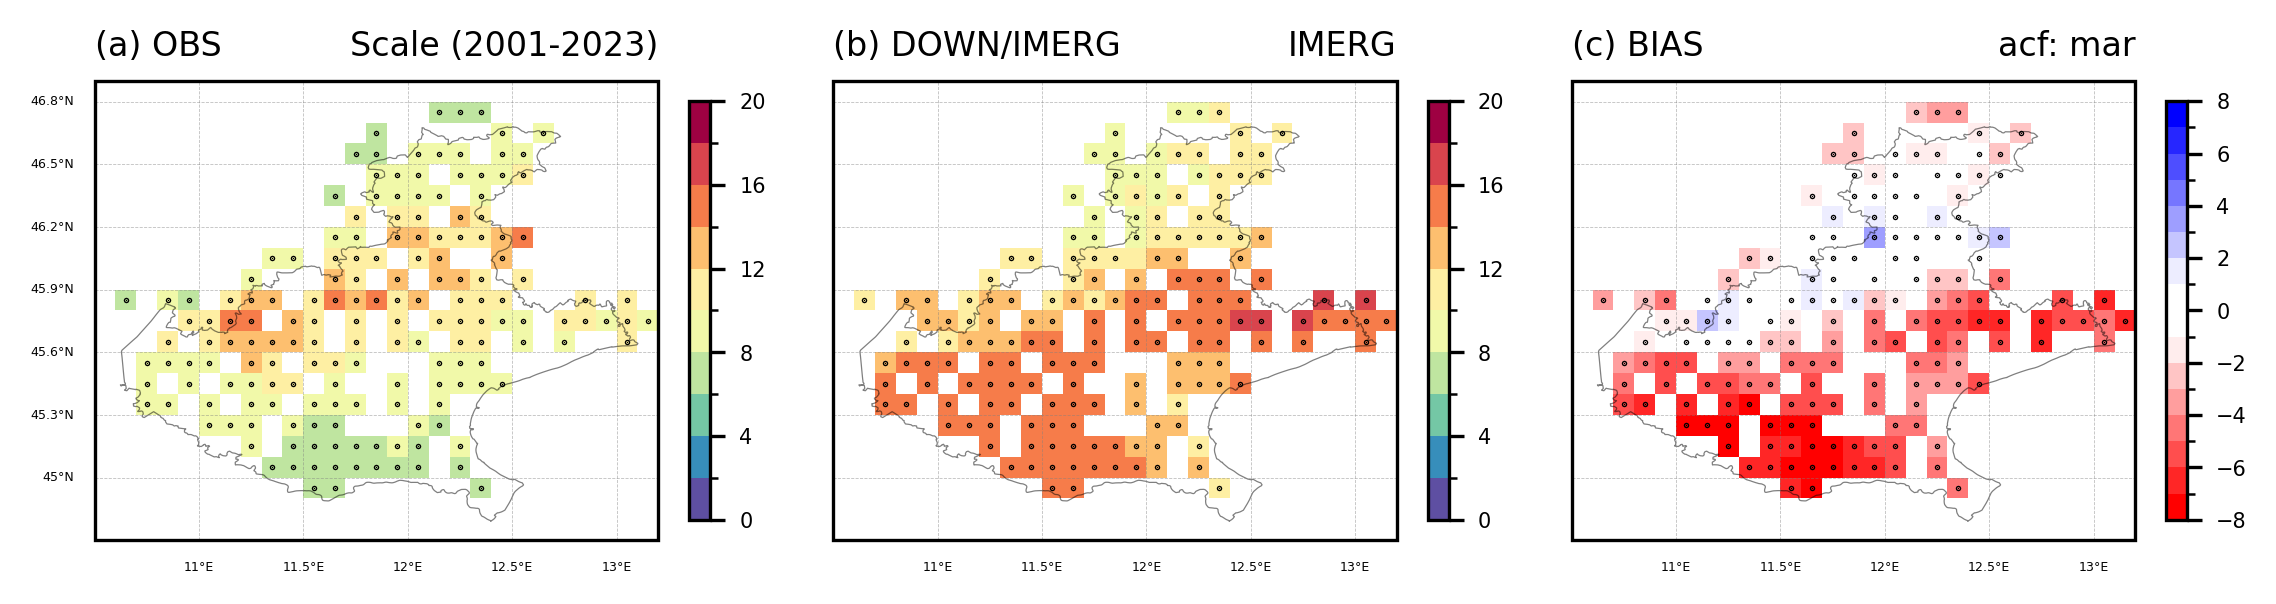

In [10]:
OBS_mean = np.nanmean(OBS['Scale'].values,axis=0)
DOWN_mean = np.nanmean(DATA['DOWN_SC'].values,axis=0)

val_min = round_down_to_nearest_10(np.min([np.nanmin(OBS_mean), np.nanmin(DOWN_mean)]))
val_max = round_up_to_nearest_10(np.max([np.nanmax(OBS_mean), np.nanmax(DOWN_mean)]))

levels_wd = np.arange(val_min,val_max+2,2)
norm_wd = mcolors.BoundaryNorm(boundaries=levels_wd, ncolors=256)

levels_diff = np.arange(-8,9,1)
norm_diff = mcolors.BoundaryNorm(boundaries=levels_diff, ncolors=256)

cmap_wd = plt.cm.Spectral_r
cmpa_diff = plt.cm.bwr_r
cmpa_diff = ca.colorbar_middle_white(cmpa_diff)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) OBS', fontsize=8, loc='left')
ax1.set_title(f'Scale ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, DOWN_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) DOWN/IMERG', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean-DOWN_mean, cmap=cmpa_diff, norm=norm_diff)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) BIAS', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

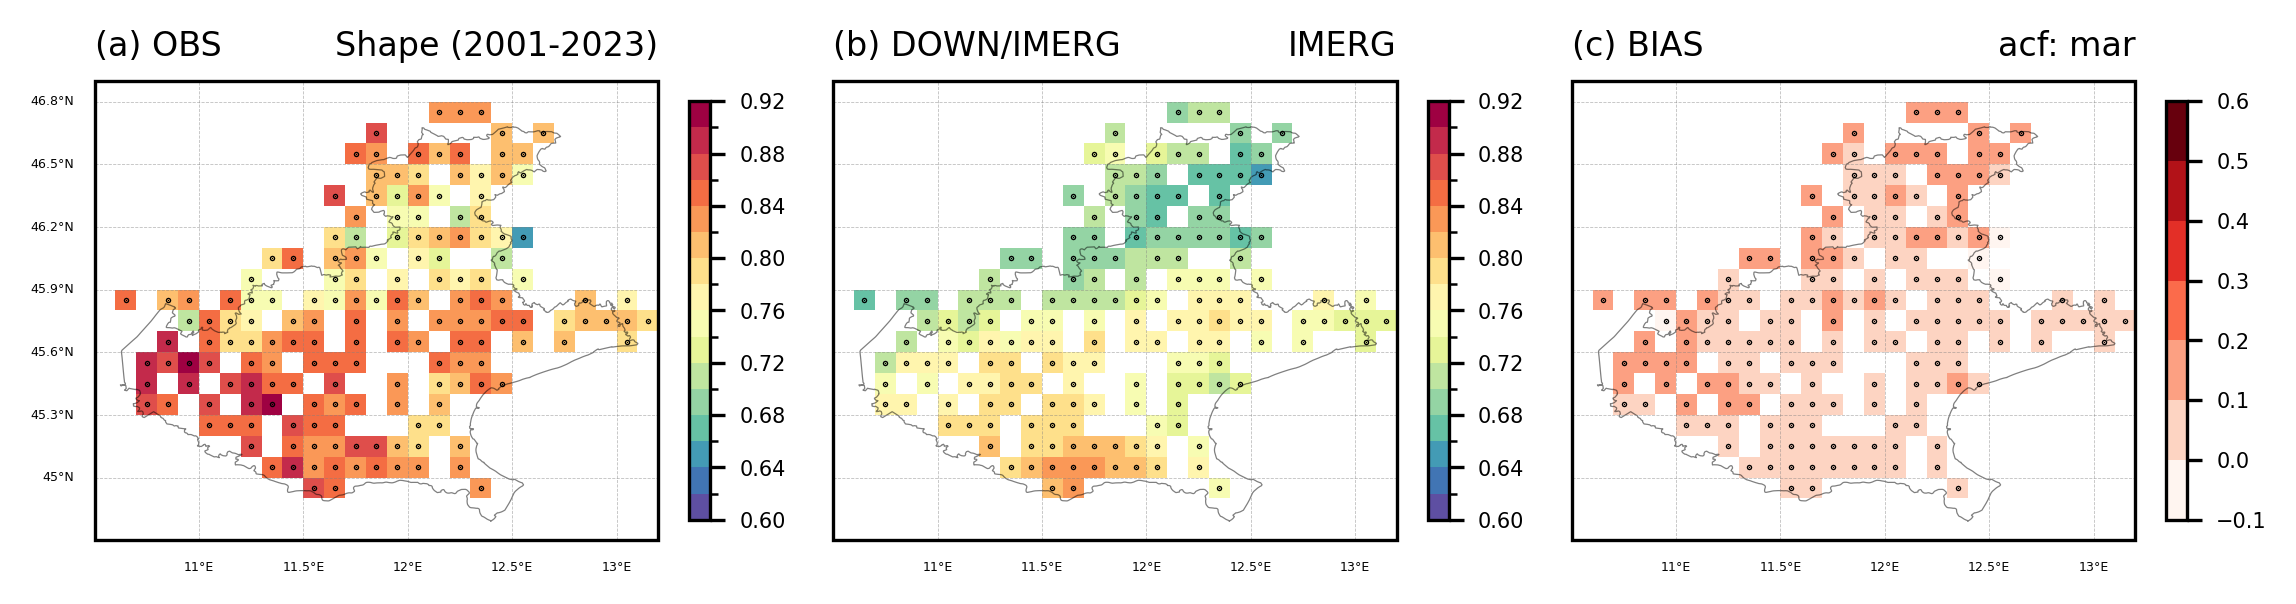

In [11]:
OBS_mean = np.nanmean(OBS['Shape'].values,axis=0)
DOWN_mean = np.nanmean(DATA['DOWN_SH'].values,axis=0)

levels_wd = np.arange(0.6,0.9+0.02,0.02)
norm_wd = mcolors.BoundaryNorm(boundaries=levels_wd, ncolors=256)

levels_diff = np.arange(-0.1,0.7,0.1)
norm_diff = mcolors.BoundaryNorm(boundaries=levels_diff, ncolors=256)

cmap_wd = plt.cm.Spectral_r
cmpa_diff = plt.cm.Reds

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) OBS', fontsize=8, loc='left')
ax1.set_title(f'Shape ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, DOWN_mean, cmap=cmap_wd, norm=norm_wd)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) DOWN/IMERG', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, OBS_mean-DOWN_mean, cmap=cmpa_diff, norm=norm_diff)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) BIAS', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

## RMSE

In [12]:
RMSE_WD = RMSE_2d(OBS['Wetdays'].values, DATA['DOWN_WD'].values)
RMSE_SC = RMSE_2d(OBS['Scale'].values, DATA['DOWN_SC'].values)
RMSE_SH = RMSE_2d(OBS['Shape'].values, DATA['DOWN_SH'].values)

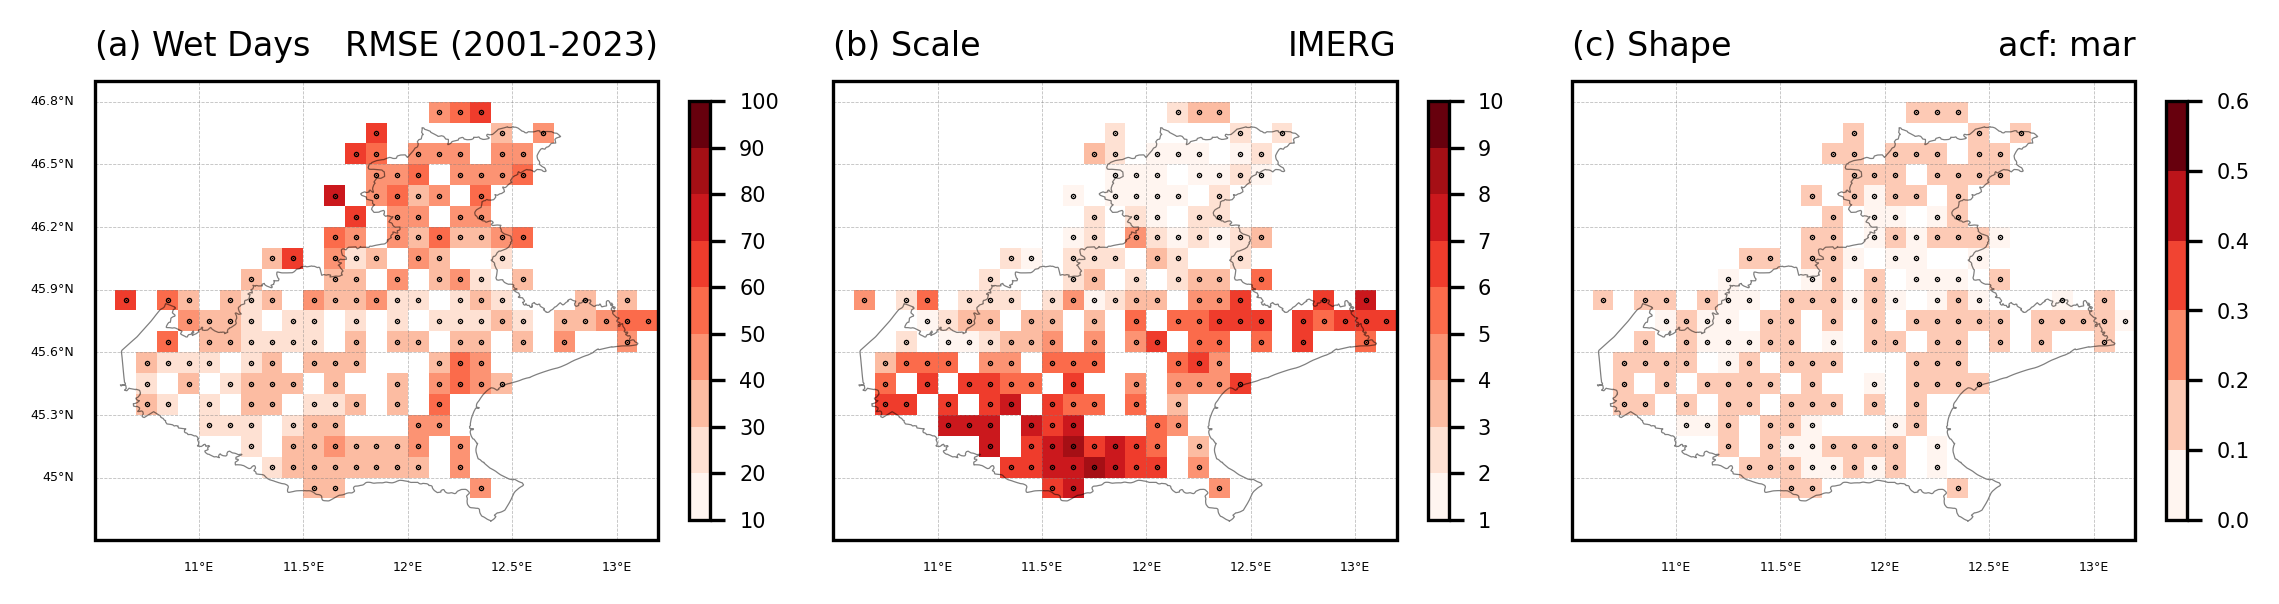

In [13]:
levels_WD = np.arange(10, 110, 10)
norm_WD = mcolors.BoundaryNorm(boundaries=levels_WD, ncolors=256)

levels_SC = np.arange(1, 11, 1)
norm_SC = mcolors.BoundaryNorm(boundaries=levels_SC, ncolors=256)

levels_SH = np.arange(0, 0.7, 0.1)
norm_SH = mcolors.BoundaryNorm(boundaries=levels_SH, ncolors=256)

cmpa_cor1 = plt.cm.Reds
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, RMSE_WD, cmap=cmpa_cor1, norm=norm_WD)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
ax1.set_title(f'RMSE ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, RMSE_SC, cmap=cmpa_cor1, norm=norm_SC)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) Scale', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, RMSE_SH, cmap=cmpa_cor1, norm=norm_SH)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) Shape', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

## Spearman Correlation

In [14]:
CORR_WD = CORR_2d(OBS['Wetdays'].values, DATA['DOWN_WD'].values)
CORR_SC = CORR_2d(OBS['Scale'].values, DATA['DOWN_SC'].values)
CORR_SH = CORR_2d(OBS['Shape'].values, DATA['DOWN_SH'].values)

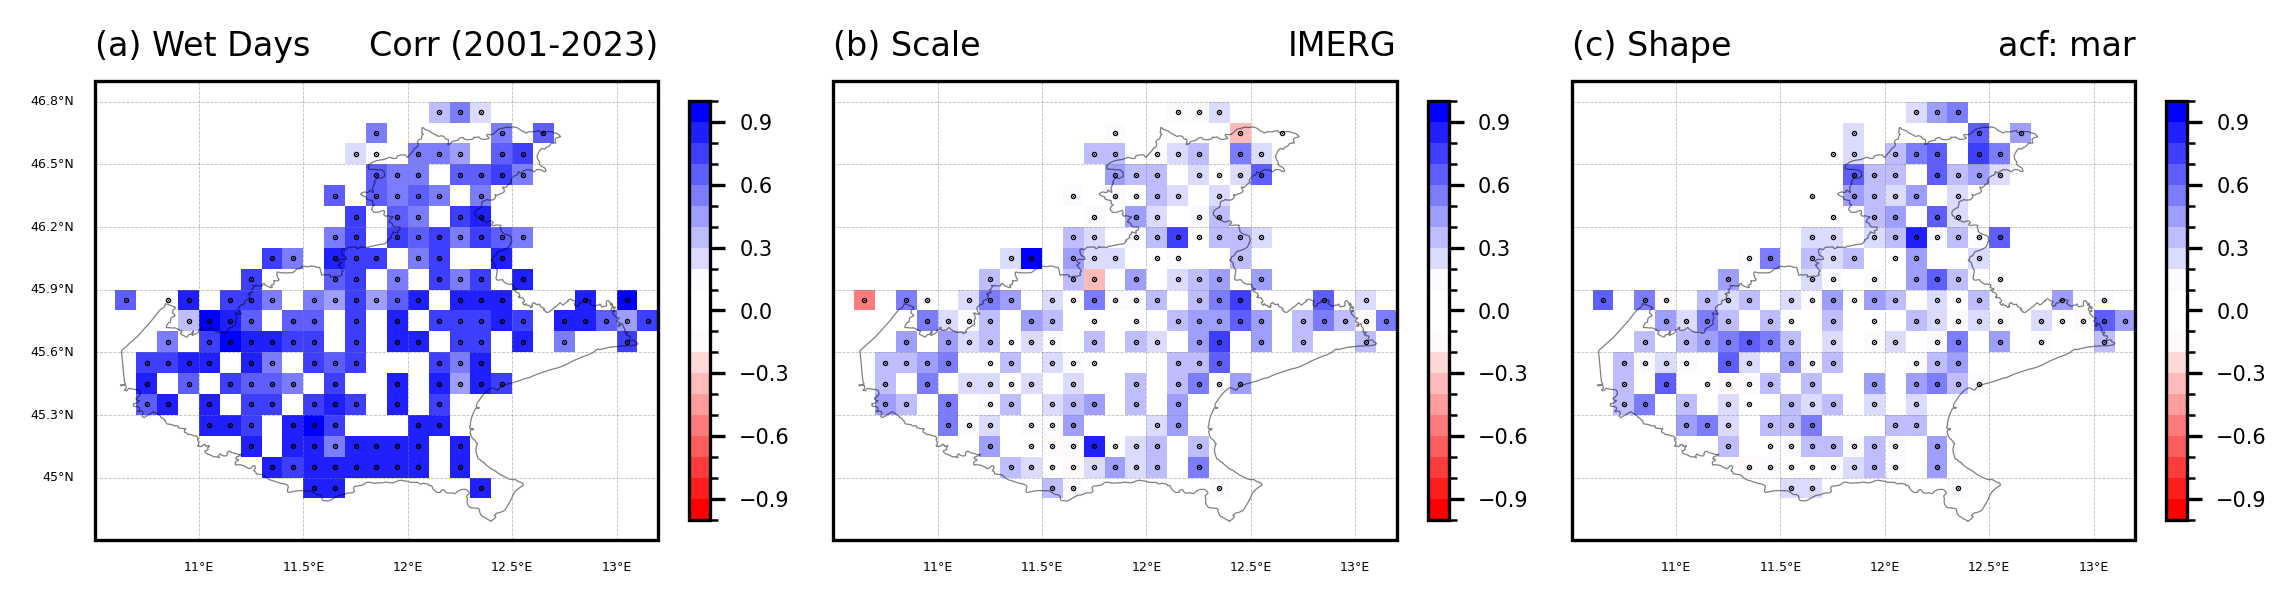

In [15]:
levels = np.arange(-1, 1.1, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap_cor = plt.cm.bwr_r
cmap_cor = ca.colorbar_middle_white(cmap_cor)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, CORR_WD, cmap=cmap_cor, norm=norm)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
ax1.set_title(f'Corr ({yys_cut}-{yye_cut})', fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, CORR_SC, cmap=cmap_cor, norm=norm)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) Scale', fontsize=8, loc='left')
ax1.set_title(product, fontsize=8, loc='right')

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, CORR_SH, cmap=cmap_cor, norm=norm)
ax1.scatter(lon2d[mask], lat2d[mask], s=0.1, c='k', marker='o')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.034)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) Shape', fontsize=8, loc='left')
ax1.set_title('acf: mar', fontsize=8, loc='right')

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

## Return Time

In [16]:
Tr = np.array([10, 20, 50, 100])
pos_10 = np.where(Tr==10)[0][0]
pos_50 = np.where(Tr==50)[0][0]
pos_100 = np.where(Tr==100)[0][0]

data_dict = {
    'WD': f'{product}_WD',
    'SC': f'{product}_SC',
    'SH': f'{product}_SH'
}

down_dict = {
    'WD': 'DOWN_WD',
    'SC': 'DOWN_SC',
    'SH': 'DOWN_SH'
}

In [17]:
DATA_Q = pre_quantiles(DATA, Tr, lat, lon, data_dict, 2)
DOWN_Q = pre_quantiles(DATA, Tr, lat, lon, down_dict, 2)

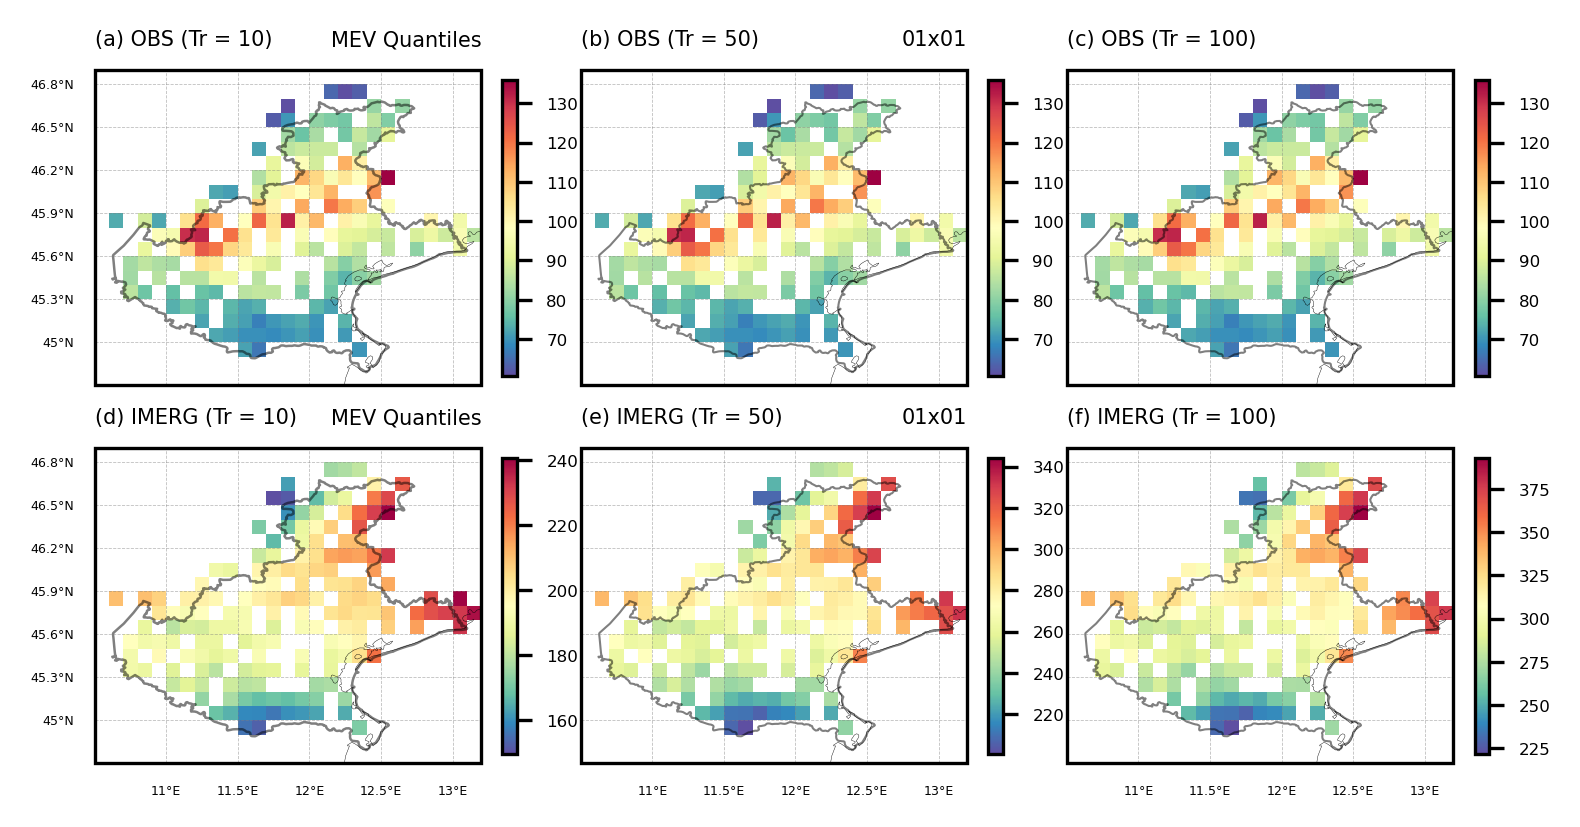

In [18]:
levels = np.arange(0, 130, 10)

norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(2,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
# ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, OBS['Quantile'][pos_10,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) OBS (Tr = {Tr[pos_10]})', loc='left', fontsize=5)
ax1.set_title('MEV Quantiles', loc='right', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
# ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a2 = ax1.pcolormesh(lon2d, lat2d, OBS['Quantile'][pos_50,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) OBS (Tr = {Tr[pos_50]})', loc='left', fontsize=5)
ax1.set_title(f'{resolution}', loc='right', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
# ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a2 = ax1.pcolormesh(lon2d, lat2d, OBS['Quantile'][pos_100,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) OBS (Tr = {Tr[pos_100]})', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
# ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, DOWN_Q[pos_10,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(d) {product} (Tr = {Tr[pos_10]})', loc='left', fontsize=5)
ax1.set_title('MEV Quantiles', loc='right', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
# ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a2 = ax1.pcolormesh(lon2d, lat2d, DOWN_Q[pos_50,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(e) {product} (Tr = {Tr[pos_50]})', loc='left', fontsize=5)
ax1.set_title(f'{resolution}', loc='right', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)
# ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)

a2 = ax1.pcolormesh(lon2d, lat2d, DOWN_Q[pos_100,:,:], cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(f) {product} (Tr = {Tr[pos_100]})', loc='left', fontsize=5)

# ============================================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.2, wspace=0.15)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## Results for Time Return 50

In [19]:
OBS_df = pd.DataFrame({'PRE':np.reshape(OBS['Quantile'][pos_50,:,:].values, len(lat)*len(lon))})
PRE_df = pd.DataFrame({'PRE':np.reshape(DATA_Q[pos_50,:,:], len(lat)*len(lon))})
DOWN_df = pd.DataFrame({'PRE':np.reshape(DOWN_Q[pos_50,:,:], len(lat)*len(lon))})

In [20]:
corrected_model = quantile_correction(OBS_df['PRE'].values, DOWN_df['PRE'].values)

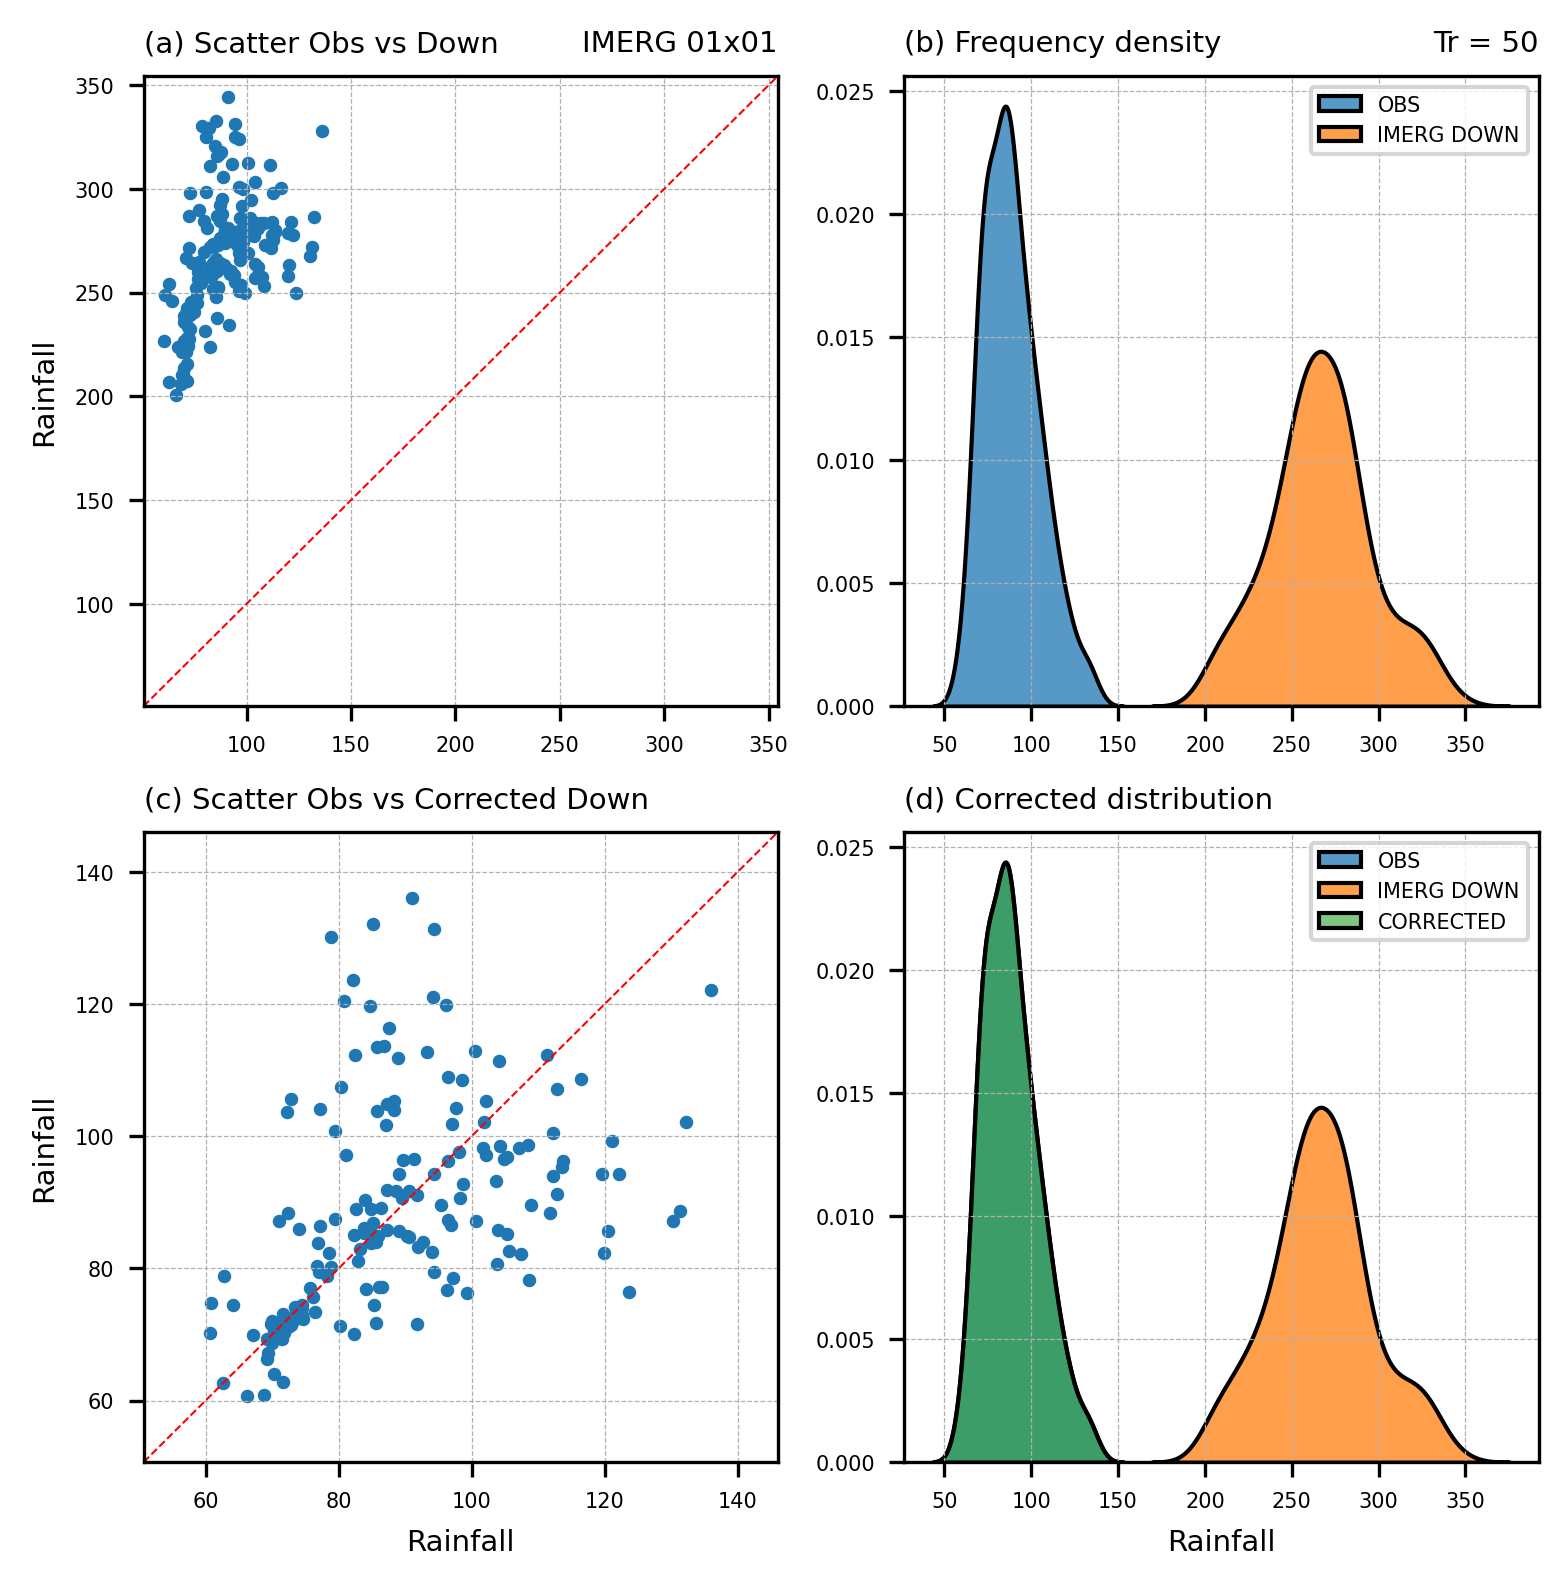

In [21]:
fig = plt.figure(figsize=(6,6),dpi=300)
gs = gridspec.GridSpec(2,2)

# ======================================================================================
ax1 = plt.subplot(gs[0, 0])
Lmin = np.min([np.min(OBS_df), np.min(DOWN_df)])
Lmax = np.max([np.max(OBS_df), np.max(DOWN_df)])

ax1.scatter(OBS_df['PRE'], DOWN_df['PRE'], s=5)
ax1.plot(np.arange(Lmin-10,Lmax+10), np.arange(Lmin-10,Lmax+10), color='r', linestyle='--', linewidth=0.5)

ax1.set_xlim([Lmin-10, Lmax+10])
ax1.set_ylim([Lmin-10, Lmax+10])
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='x', labelsize=5)
ax1.tick_params(axis='y', labelsize=5)
ax1.set_xlabel('', fontsize=7) 
ax1.set_ylabel('Rainfall', fontsize=7) 

ax1.set_title(f'(a) Scatter Obs vs Down', loc='left', fontsize=7)
ax1.set_title(f'{product} {resolution}', loc='right', fontsize=7)

# ======================================================================================
ax1 = plt.subplot(gs[0, 1])

sns.kdeplot(OBS_df['PRE'], cumulative=False, multiple="stack", ax=ax1, label='OBS')
sns.kdeplot(DOWN_df['PRE'], cumulative=False, multiple="stack", ax=ax1, label=f'{product} DOWN')

ax1.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='x', labelsize=5)
ax1.tick_params(axis='y', labelsize=5)
ax1.set_ylabel('', fontsize=8) 
ax1.set_xlabel('', fontsize=7) 

ax1.set_title(f'(b) Frequency density', loc='left', fontsize=7)
ax1.set_title(f'Tr = {Tr[pos_50]}', loc='right', fontsize=7)

# ======================================================================================
ax1 = plt.subplot(gs[1, 0])
Lmin = np.min([np.min(OBS_df), np.min(corrected_model)])
Lmax = np.max([np.max(OBS_df), np.max(corrected_model)])

ax1.scatter(OBS_df['PRE'].dropna().values, corrected_model, s=5)
ax1.plot(np.arange(Lmin-10,Lmax+10), np.arange(Lmin-10,Lmax+10), color='r', linestyle='--', linewidth=0.5)

ax1.set_xlim([Lmin-10, Lmax+10])
ax1.set_ylim([Lmin-10, Lmax+10])
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='x', labelsize=5)
ax1.tick_params(axis='y', labelsize=5)
ax1.set_xlabel('Rainfall', fontsize=7) 
ax1.set_ylabel('Rainfall', fontsize=7) 

ax1.set_title(f'(c) Scatter Obs vs Corrected Down', loc='left', fontsize=7)

# ======================================================================================
ax1 = plt.subplot(gs[1, 1])

corrected_model = quantile_correction(OBS_df['PRE'].values, DOWN_df['PRE'].values)
sns.kdeplot(OBS_df['PRE'], cumulative=False, multiple="stack", ax=ax1, label='OBS')
sns.kdeplot(DOWN_df['PRE'], cumulative=False, multiple="stack", ax=ax1, label=f'{product} DOWN')
sns.kdeplot(corrected_model, cumulative=False, multiple="stack", alpha=0.6, ax=ax1, label=f'CORRECTED')

ax1.legend(fontsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='x', labelsize=5)
ax1.tick_params(axis='y', labelsize=5)
ax1.set_ylabel('', fontsize=8) 
ax1.set_xlabel('Rainfall', fontsize=7) 

ax1.set_title(f'(d) Corrected distribution', loc='left', fontsize=7)

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.2, wspace=0.2)

In [22]:
non_nan_indices = OBS_df['PRE'].notna()
DOWN_df.loc[non_nan_indices, 'CORRECT'] = corrected_model

In [23]:
ERROR_DOWN = relative_error(np.reshape(OBS_df['PRE'].values,(len(lat),len(lon))), np.reshape(DOWN_df['PRE'].values,(len(lat),len(lon))))
ERROR_CORRECT = relative_error(np.reshape(OBS_df['PRE'].values,(len(lat),len(lon))), np.reshape(DOWN_df['CORRECT'].values,(len(lat),len(lon))))

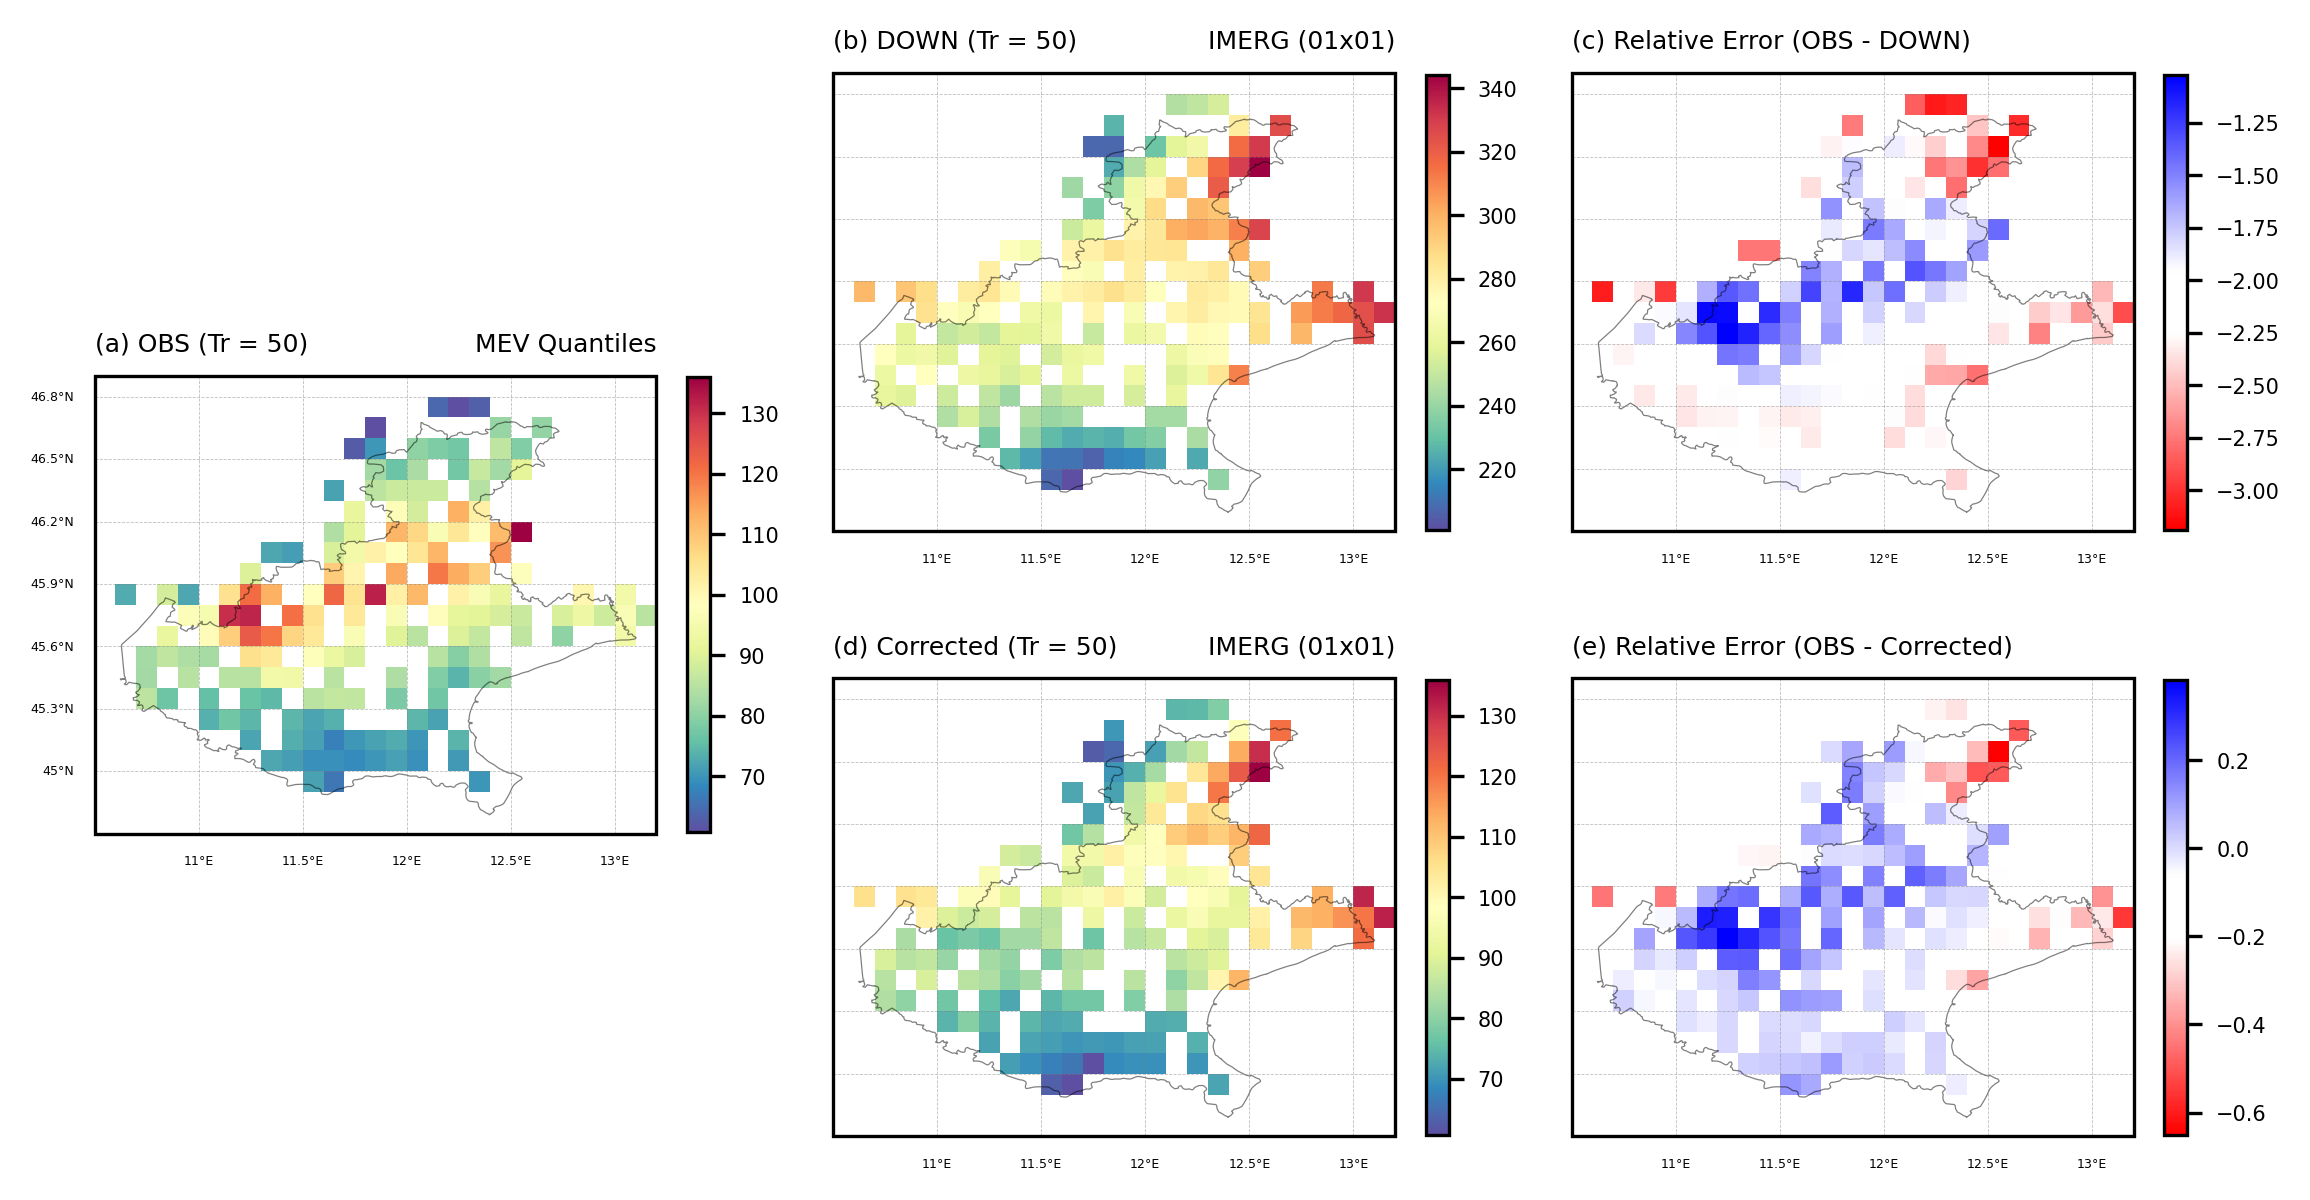

In [24]:
levels = np.arange(-1, 1.1, 0.1)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
cmpa_diff = plt.cm.bwr_r
cmpa_diff = ca.colorbar_middle_white(cmpa_diff)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,5),dpi=300)
gs = gridspec.GridSpec(2,3)

# ======================================================================================
ax1 = plt.subplot(gs[0:2, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.reshape(OBS_df['PRE'].values,(len(lat),len(lon))), cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.037)
cbar.ax.tick_params(labelsize=5)

ax1.set_title(f'(a) OBS (Tr = {Tr[pos_50]})', loc='left', fontsize=6)
ax1.set_title('MEV Quantiles', loc='right', fontsize=6)

# ======================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.reshape(DOWN_df['PRE'].values,(len(lat),len(lon))), cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.037)
cbar.ax.tick_params(labelsize=5)

ax1.set_title(f'(b) DOWN (Tr = {Tr[pos_50]})', loc='left', fontsize=6)
ax1.set_title(f'{product} ({resolution})', loc='right', fontsize=6)

# ======================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, ERROR_DOWN, cmap=cmpa_diff)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.037)
cbar.ax.tick_params(labelsize=5)

ax1.set_title(f'(c) Relative Error (OBS - DOWN)', loc='left', fontsize=6)

# ======================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
a1 = ax1.pcolormesh(lon2d, lat2d, np.reshape(DOWN_df['CORRECT'].values,(len(lat),len(lon))), cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.037)
cbar.ax.tick_params(labelsize=5)

ax1.set_title(f'(d) Corrected (Tr = {Tr[pos_50]})', loc='left', fontsize=6)
ax1.set_title(f'{product} ({resolution})', loc='right', fontsize=6)

# ======================================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.3, alpha=0.5)
ERROR = np.reshape(OBS_df['PRE'].values,(len(lat),len(lon))) - np.reshape(DOWN_df['CORRECT'].values,(len(lat),len(lon)))
a1 = ax1.pcolormesh(lon2d, lat2d, ERROR_CORRECT, cmap=cmpa_diff)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.037)
cbar.ax.tick_params(labelsize=5)

ax1.set_title(f'(e) Relative Error (OBS - Corrected)', loc='left', fontsize=6)

# ======================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.2)

## Boxplot

In [26]:
colors_manual = [
        (0.42000000000000004, 0.6333333333333333, 0.8466666666666667, 0.5),
        (0.7400000000000001, 0.31333333333333335, 0.7400000000000001, 0.5),
        (0.5800000000000001, 0.9, 0.3666666666666667, 0.5)]

### IMERG AND OBS

In [27]:
data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_IMERG_2001_2023.nc')
print(f'IMERG load: {data_dir}')
DATA = xr.open_dataset(data_dir)

nlat = len(DATA['lat'])
nlon = len(DATA['lon'])
ntime = len(DATA['time'])

IMERG_WD = np.reshape(DATA['DOWN_WD'].values,ntime*nlat*nlon)
IMERG_WD = IMERG_WD[~np.isnan(IMERG_WD)]

IMERG_SC = np.reshape(DATA['DOWN_SC'].values,ntime*nlat*nlon)
IMERG_SC = IMERG_SC[~np.isnan(IMERG_SC)]

IMERG_SH = np.reshape(DATA['DOWN_SH'].values,ntime*nlat*nlon)
IMERG_SH = IMERG_SH[~np.isnan(IMERG_SH)]

# ==================================================================================
OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_IMERG_1981_2023.nc')
print(f'OBS load: {OBS_dir}')
OBS = xr.open_dataset(OBS_dir)
OBS = OBS.sel(time=OBS.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

nlat = len(OBS['lat'])
nlon = len(OBS['lon'])
ntime = len(OBS['time'])

OBS_WD_clear = np.reshape(OBS['Wetdays'].values,ntime*nlat*nlon)
OBS_WD_clear = OBS_WD_clear[~np.isnan(OBS_WD_clear)]

OBS_SC_clear = np.reshape(OBS['Scale'].values,ntime*nlat*nlon)
OBS_SC_clear = OBS_SC_clear[~np.isnan(OBS_SC_clear)]

OBS_SH_clear = np.reshape(OBS['Shape'].values,ntime*nlat*nlon)
OBS_SH_clear = OBS_SH_clear[~np.isnan(OBS_SH_clear)]

IMERG load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_IMERG_2001_2023.nc
OBS load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_OBS_IMERG_1981_2023.nc


[Text(0.0, 0, 'OBS'), Text(0.5, 0, 'IMERG')]

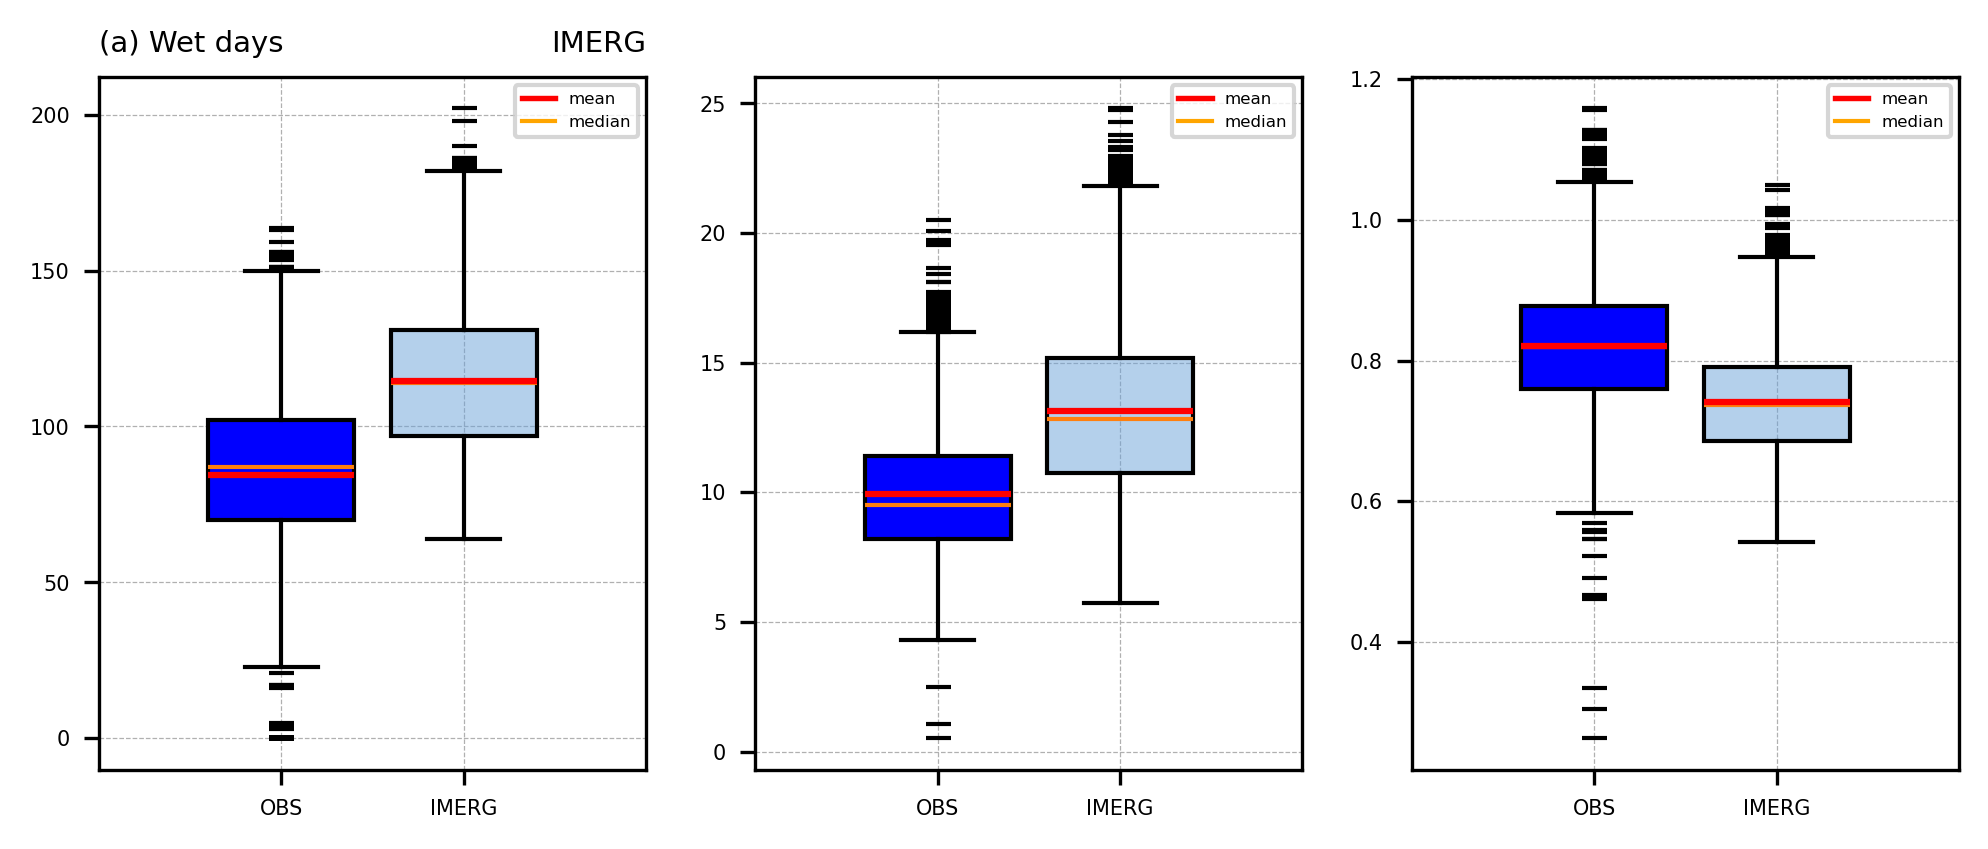

In [28]:
outliers = True

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)
plt.style.use('default')

# =======================================================================================
ax1 = plt.subplot(gs[0, 0])
box = ax1.boxplot(OBS_WD_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_WD,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

ax1.set_title('(a) Wet days', fontsize=7, loc='left')
ax1.set_title('IMERG', fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 1])
box = ax1.boxplot(OBS_SC_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_SC,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================
ax1 = plt.subplot(gs[0, 2])
box = ax1.boxplot(OBS_SH_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_SH,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================

### IMERG 0.25x0.25 AND OBS

In [29]:
data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_IMERG_025x025_2001_2023.nc')
print(f'IMERG 0.25x0.25 load: {data_dir}')
DATA = xr.open_dataset(data_dir)

nlat = len(DATA['lat'])
nlon = len(DATA['lon'])
ntime = len(DATA['time'])

IMERG_025_WD = np.reshape(DATA['DOWN_WD'].values,ntime*nlat*nlon)
IMERG_025_WD = IMERG_025_WD[~np.isnan(IMERG_025_WD)]

IMERG_025_SC = np.reshape(DATA['DOWN_SC'].values,ntime*nlat*nlon)
IMERG_025_SC = IMERG_025_SC[~np.isnan(IMERG_025_SC)]

IMERG_025_SH = np.reshape(DATA['DOWN_SH'].values,ntime*nlat*nlon)
IMERG_025_SH = IMERG_025_SH[~np.isnan(IMERG_025_SH)]

# ==================================================================================
OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_IMERG_025x025_1981_2023.nc')
print(f'OBS load: {OBS_dir}')
OBS = xr.open_dataset(OBS_dir)
OBS = OBS.sel(time=OBS.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

nlat = len(OBS['lat'])
nlon = len(OBS['lon'])
ntime = len(OBS['time'])

OBS_WD_clear = np.reshape(OBS['Wetdays'].values,ntime*nlat*nlon)
OBS_WD_clear = OBS_WD_clear[~np.isnan(OBS_WD_clear)]

OBS_SC_clear = np.reshape(OBS['Scale'].values,ntime*nlat*nlon)
OBS_SC_clear = OBS_SC_clear[~np.isnan(OBS_SC_clear)]

OBS_SH_clear = np.reshape(OBS['Shape'].values,ntime*nlat*nlon)
OBS_SH_clear = OBS_SH_clear[~np.isnan(OBS_SH_clear)]

IMERG 0.25x0.25 load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_IMERG_025x025_2001_2023.nc
OBS load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_OBS_IMERG_025x025_1981_2023.nc


[Text(0.0, 0, 'OBS'), Text(0.5, 0, 'IMERG')]

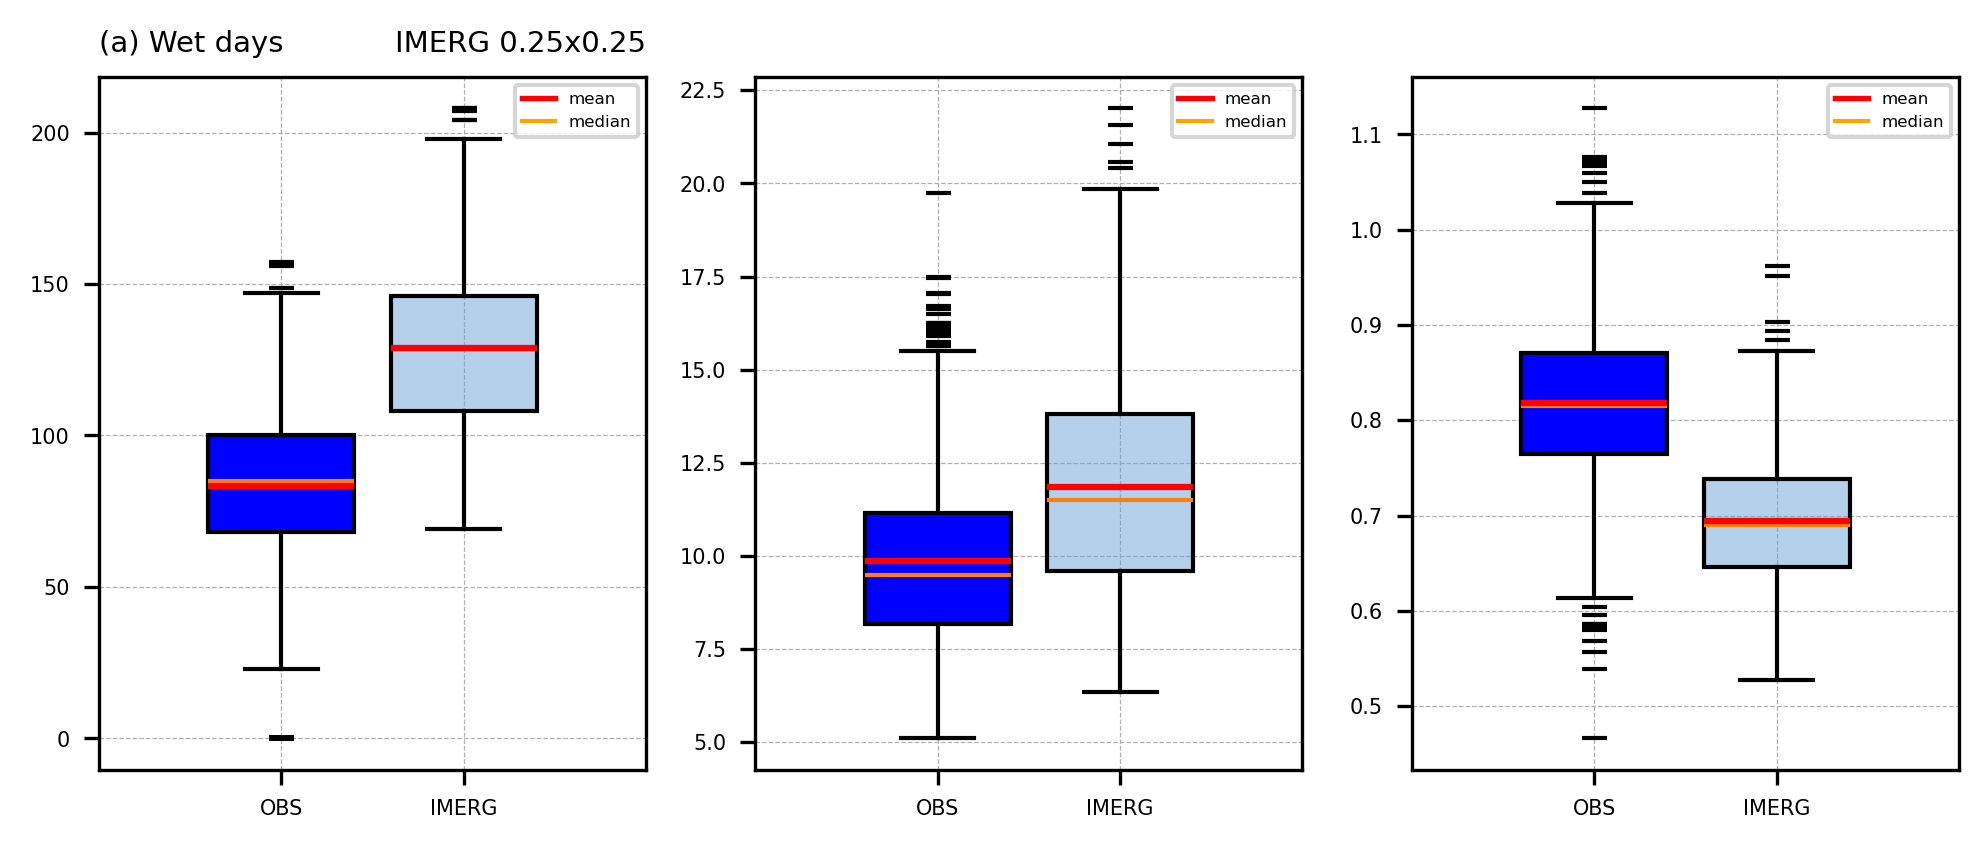

In [30]:
outliers = True

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)
plt.style.use('default')

# =======================================================================================
ax1 = plt.subplot(gs[0, 0])
box = ax1.boxplot(OBS_WD_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_WD,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

ax1.set_title('(a) Wet days', fontsize=7, loc='left')
ax1.set_title('IMERG 0.25x0.25', fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 1])
box = ax1.boxplot(OBS_SC_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_SC,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================
ax1 = plt.subplot(gs[0, 2])
box = ax1.boxplot(OBS_SH_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_SH,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================


### CMORPH

In [31]:
data_dir = os.path.join(dir_base,f'VENETO_WEIBULL_CMORPH_1998_2023.nc')
print(f'CMORPH load: {data_dir}')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

nlat = len(DATA['lat'])
nlon = len(DATA['lon'])
ntime = len(DATA['time'])

CMORPH_WD = np.reshape(DATA['DOWN_WD'].values,ntime*nlat*nlon)
CMORPH_WD = CMORPH_WD[~np.isnan(CMORPH_WD)]

CMORPH_SC = np.reshape(DATA['DOWN_SC'].values,ntime*nlat*nlon)
CMORPH_SC = CMORPH_SC[~np.isnan(CMORPH_SC)]

CMORPH_SH = np.reshape(DATA['DOWN_SH'].values,ntime*nlat*nlon)
CMORPH_SH = CMORPH_SH[~np.isnan(CMORPH_SH)]

# ==================================================================================
OBS_dir = os.path.join(dir_base,f'VENETO_WEIBULL_OBS_CMORPH_1981_2023.nc')
print(f'OBS load: {OBS_dir}')
OBS = xr.open_dataset(OBS_dir)
OBS = OBS.sel(time=OBS.time.dt.year.isin([np.arange(yys_cut,yye_cut+1)]))

nlat = len(OBS['lat'])
nlon = len(OBS['lon'])
ntime = len(OBS['time'])

OBS_WD_clear = np.reshape(OBS['Wetdays'].values,ntime*nlat*nlon)
OBS_WD_clear = OBS_WD_clear[~np.isnan(OBS_WD_clear)]

OBS_SC_clear = np.reshape(OBS['Scale'].values,ntime*nlat*nlon)
OBS_SC_clear = OBS_SC_clear[~np.isnan(OBS_SC_clear)]

OBS_SH_clear = np.reshape(OBS['Shape'].values,ntime*nlat*nlon)
OBS_SH_clear = OBS_SH_clear[~np.isnan(OBS_SH_clear)]

CMORPH load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_CMORPH_1998_2023.nc
OBS load: /media/arturo/Arturo/Data/Italy/Weibull/VENETO_WEIBULL_OBS_CMORPH_1981_2023.nc


[Text(0.0, 0, 'OBS'), Text(0.5, 0, 'IMERG')]

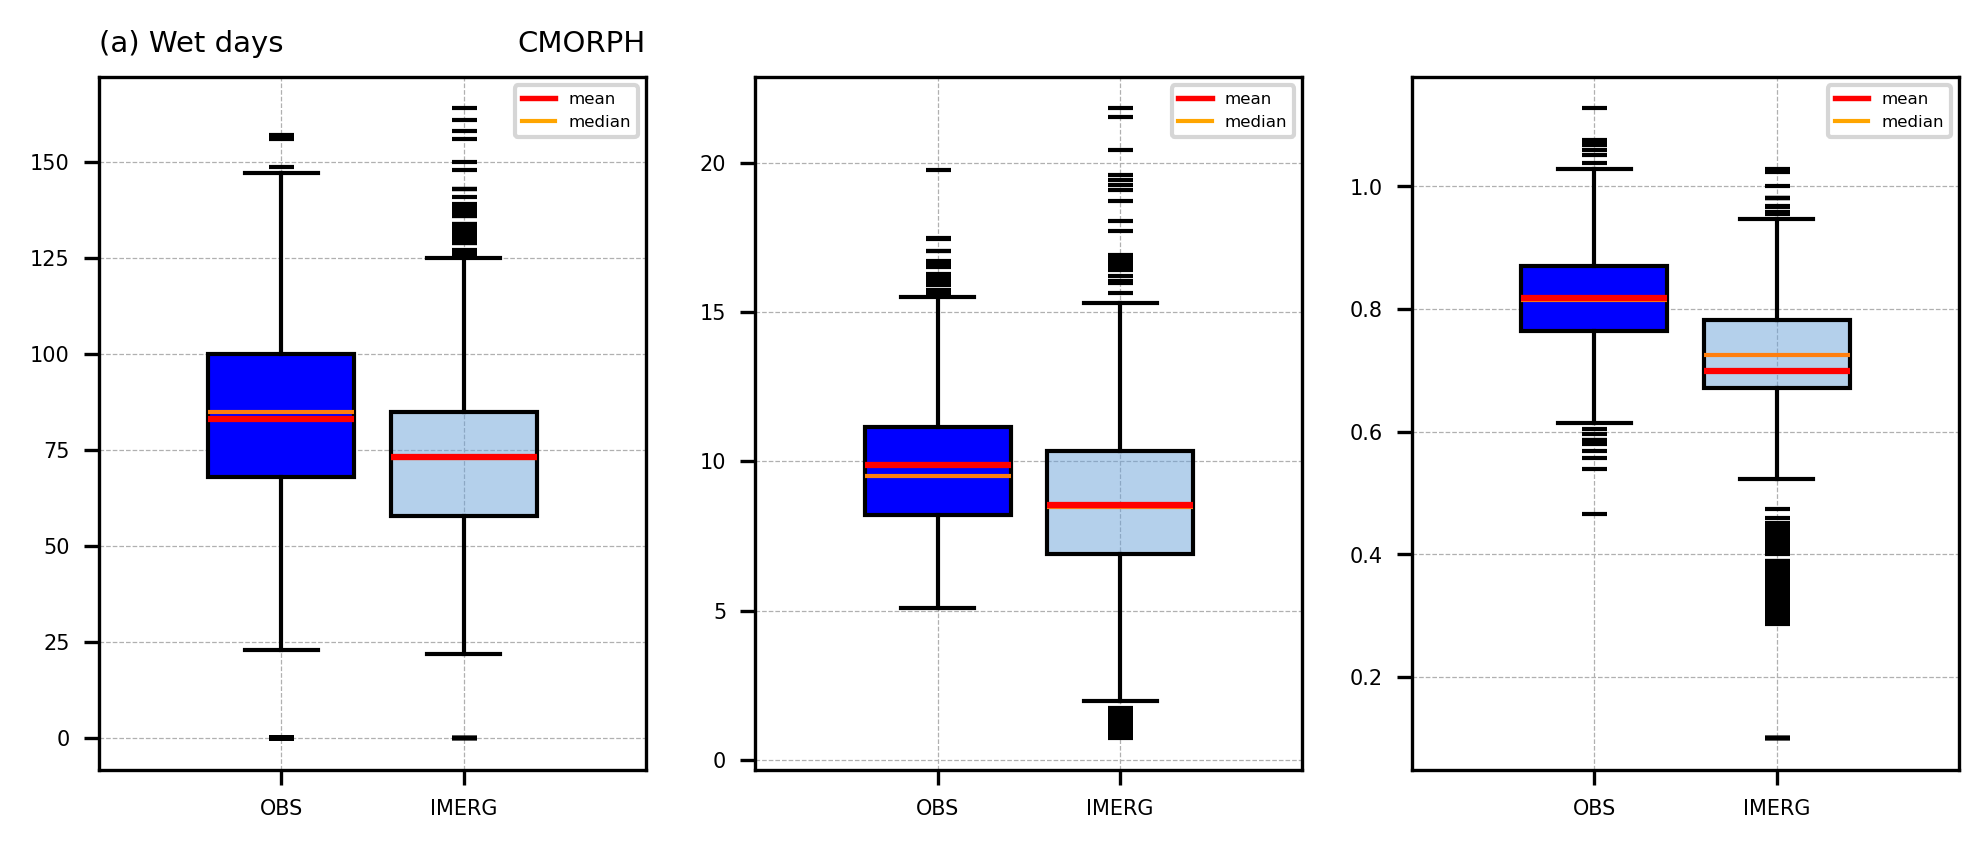

In [32]:
outliers = True

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)
plt.style.use('default')

# =======================================================================================
ax1 = plt.subplot(gs[0, 0])
box = ax1.boxplot(OBS_WD_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_WD,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

ax1.set_title('(a) Wet days', fontsize=7, loc='left')
ax1.set_title('CMORPH', fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 1])
box = ax1.boxplot(OBS_SC_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_SC,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================
ax1 = plt.subplot(gs[0, 2])
box = ax1.boxplot(OBS_SH_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_SH,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5])
ax1.set_xticklabels(['OBS', 'IMERG'], fontsize=5)

# =======================================================================================

Text(0.0, 1.0, '(c) Shape')

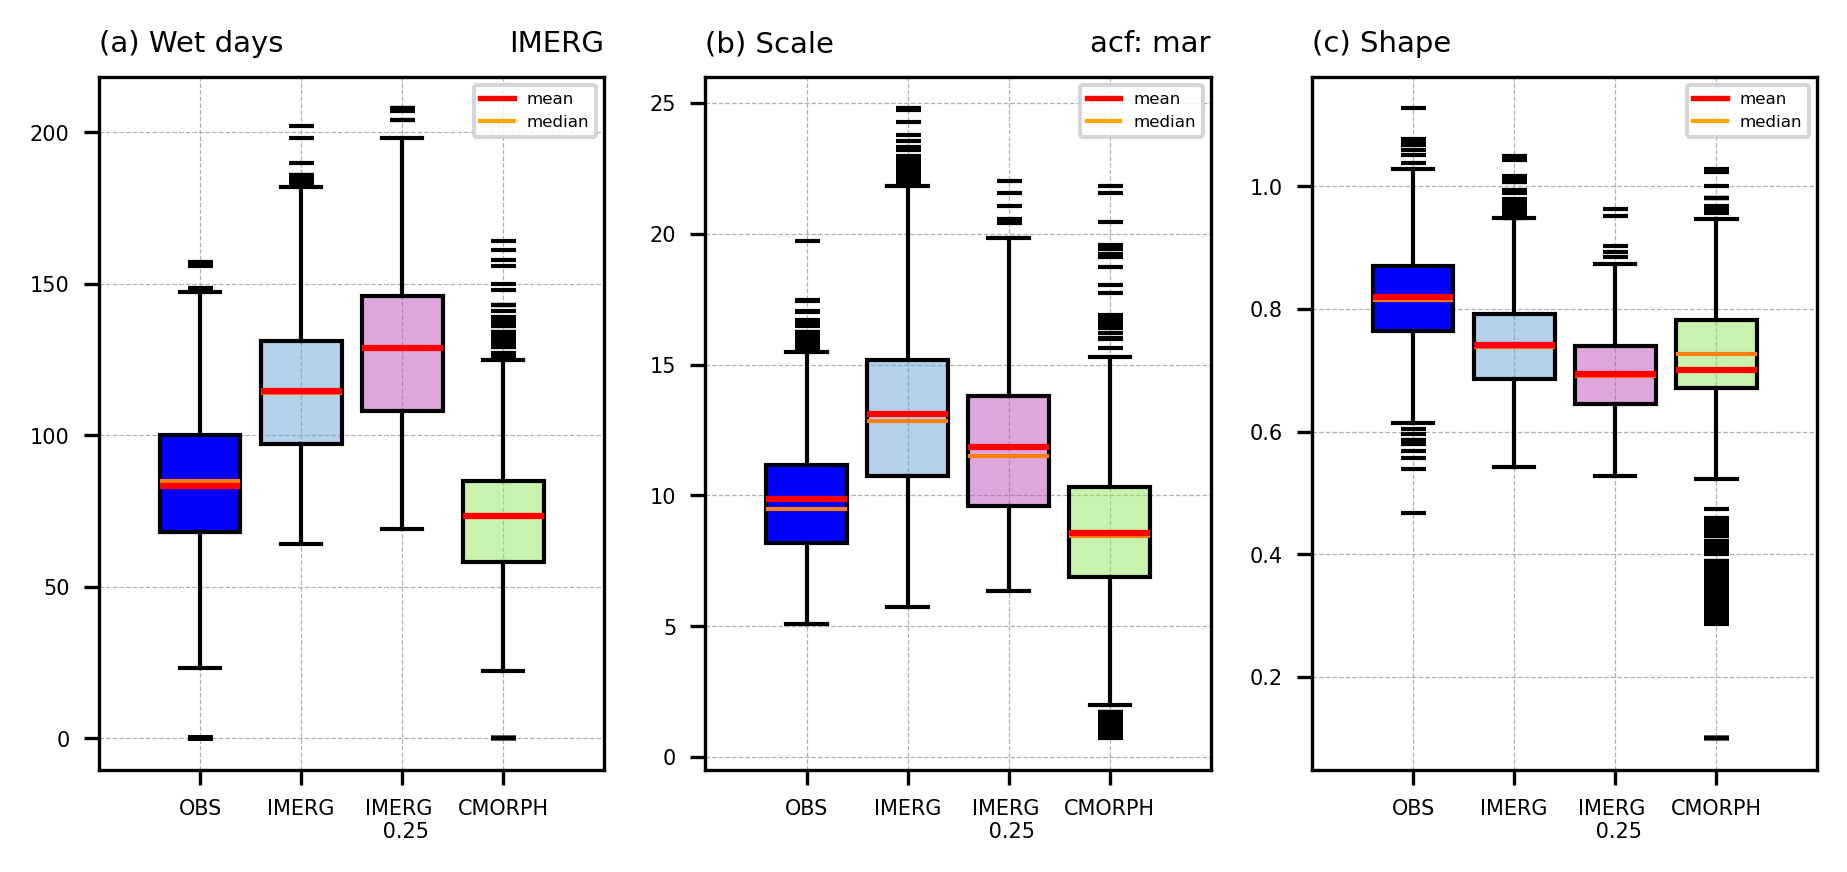

In [33]:
outliers = True

fig = plt.figure(figsize=(10,3),dpi=300)
gs = gridspec.GridSpec(1,4)
plt.style.use('default')

# =======================================================================================
ax1 = plt.subplot(gs[0, 0])
box = ax1.boxplot(OBS_WD_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_WD,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_WD,positions=[1],
widths=0.4,boxprops=dict(facecolor=colors_manual[1]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_WD,positions=[1.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[2]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5, 1, 1.5])
ax1.set_xticklabels(['OBS', 'IMERG', 'IMERG \n 0.25', 'CMORPH'], fontsize=5)

ax1.set_title('(a) Wet days', fontsize=7, loc='left')
ax1.set_title(product, fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 1])
box = ax1.boxplot(OBS_SC_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_SC,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_SC,positions=[1],
widths=0.4,boxprops=dict(facecolor=colors_manual[1]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_SC,positions=[1.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[2]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5, 1, 1.5])
ax1.set_xticklabels(['OBS', 'IMERG', 'IMERG \n 0.25', 'CMORPH'], fontsize=5)

ax1.set_title('(b) Scale', fontsize=7, loc='left')
ax1.set_title('acf: mar', fontsize=7, loc='right')

# =======================================================================================
ax1 = plt.subplot(gs[0, 2])
box = ax1.boxplot(OBS_SH_clear,positions=[0],
widths=0.4,boxprops=dict(facecolor='b'),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_SH,positions=[0.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[0]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(IMERG_025_SH,positions=[1],
widths=0.4,boxprops=dict(facecolor=colors_manual[1]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

box = ax1.boxplot(CMORPH_SH,positions=[1.5],
widths=0.4,boxprops=dict(facecolor=colors_manual[2]),
showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
showfliers=outliers,flierprops=dict(marker='_',color='k',linewidth=1.5),
patch_artist=True,notch=False)

ax1.grid(linestyle='--', linewidth=0.3)
plt.yticks(fontsize=5, rotation=0)
plt.xticks(fontsize=5, rotation=0)

ax1.plot([],[],'-',c='red',linewidth=1.3,label='mean')
ax1.plot([],[],'-',c='orange',linewidth=1,label='median')
ax1.legend(fontsize=4)

ax1.set_xticks([0, 0.5, 1, 1.5])
ax1.set_xticklabels(['OBS', 'IMERG', 'IMERG \n 0.25', 'CMORPH'], fontsize=5)

ax1.set_title('(c) Shape', fontsize=7, loc='left')

## MEV quantile for given non exceedance probability